# Homework 2

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

### Anvita Panandikar (ID: 12372196)

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


# Problem 1: Constructing fixed rate bonds

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format
sns.set_theme()
sns.set(font_scale=1.3)

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

## a. Prepare common symbology dataframe for fixed rate government and corporate bonds

Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").


In [2]:
govt = pd.read_excel('govt_symbology.xlsx')
corp = pd.read_excel('corp_symbology.xlsx')

In [3]:
symbology = pd.concat([govt, corp])
symbology = symbology[symbology.columns[symbology.columns.isin(corp.columns)]]
symbology = symbology[symbology['cpn_type'] == 'FIXED']
symbology = symbology.reset_index(drop=True)

symbology

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,days_settle,start_date,cpn_first,acc_first,maturity,country,currency,und_bench_isin,mty_typ,rank
0,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.25,FIXED,...,1,1993-08-16,1994-02-15,1993-08-15,2023-08-15,US,USD,NaN,NaN,NaN
1,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.50,FIXED,...,1,1994-08-15,1994-11-15,1994-05-15,2024-11-15,US,USD,NaN,NaN,NaN
2,T,Govt,BBG000DLBVY0,US912810ET17,TSRYS4493812,T 7 5/8 02/15/25,US TREASURY N/B,US GOVERNMENT,7.62,FIXED,...,1,1995-02-15,1995-08-15,1995-02-15,2025-02-15,US,USD,NaN,NaN,NaN
3,T,Govt,BBG000DQQNJ8,US912810EV62,TSRYS4493813,T 6 7/8 08/15/25,US TREASURY N/B,US GOVERNMENT,6.88,FIXED,...,1,1995-08-15,1996-02-15,1995-08-15,2025-08-15,US,USD,NaN,NaN,NaN
4,T,Govt,BBG000DPXMD0,US912810EW46,TSRYS4493814,T 6 02/15/26,US TREASURY N/B,US GOVERNMENT,6.00,FIXED,...,1,1996-02-15,1996-08-15,1996-02-15,2026-02-15,US,USD,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.15,FIXED,...,2,2022-05-19,2022-11-15,2022-05-19,2029-05-15,US,USD,US91282CGT27,CALLABLE,Sr Unsecured
547,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.65,FIXED,...,2,2022-06-03,2022-12-15,2022-06-03,2052-06-15,US,USD,US912810TL26,CALLABLE,Sr Unsecured
548,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.60,FIXED,...,2,2022-08-11,2023-02-15,2022-08-11,2052-08-15,US,USD,US912810TL26,CALLABLE,Sr Unsecured
549,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.50,FIXED,...,2,2022-09-22,2023-03-15,2022-09-22,2029-09-15,US,USD,US91282CGT27,CALLABLE,Sr Unsecured


## b. Add function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [4]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [5]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary
       (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity']) # use date helper function and update code !!!
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first']) # use date helper function and update code !!!
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(int(details['cpn_freq']))
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

## c. Add function to construct generic fixed rate bond objects from symbology data

Use one row of the symbology dataframe as input to the function. Use create_schedule_from_symbology() internally to create the cashflow schedule.

In [6]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary
       (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA) # update code depending on dcc !!!
    else:
        day_count = ql.Thirty360(ql.Thirty360.USA) # update code depending on dcc !!!
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date']) # use date helper function and update code !!!
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Pick one government and one corporate bond from symbology, create the bond objects and display the future cashflows.

In [7]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    
    # update code!!!
    x = [(cf.date(), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_amount = zip(*x)

    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
    cashflows_df = cashflows_df[cashflows_df['CashFlowDate'] > calc_date]
    cashflows_df = cashflows_df.reset_index(drop=True)
    
    fracs = [bond.dayCounter().yearFraction(calc_date, ref_date) for ref_date in cashflows_df['CashFlowDate']]
    cashflows_df['CashFlowYearFrac'] = fracs
    
    return cashflows_df

#### Testing for a Government Bond

As seen below, the get_bond_cashflows function works as expected generating cashflows after the reference date of 4/14/2023 with a semi-annual coupon rate of 6.75% and maturity date of 8/15/2026.

In [8]:
symbology.iloc[5]

ticker                              T
class                            Govt
figi                     BBG000DXNXW9
isin                     US912810EX29
trace                    TSRYS4493815
security             T 6 3/4 08/15/26
name                  US TREASURY N/B
type                    US GOVERNMENT
coupon                           6.75
cpn_type                        FIXED
dcc                           ACT/ACT
cpn_freq                         2.00
days_settle                         1
start_date        1996-08-15 00:00:00
cpn_first         1997-02-15 00:00:00
acc_first         1996-08-15 00:00:00
maturity          2026-08-15 00:00:00
country                            US
currency                          USD
und_bench_isin                    NaN
mty_typ                           NaN
rank                              NaN
Name: 5, dtype: object

In [9]:
govt_bond = create_bond_from_symbology(symbology.iloc[5])

get_bond_cashflows(govt_bond, ql.Date(14, 4, 2023))

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"August 15th, 2023",3.37,0.33
1,"February 15th, 2024",3.37,0.83
2,"August 15th, 2024",3.37,1.33
3,"February 15th, 2025",3.37,1.83
4,"August 15th, 2025",3.37,2.33
5,"February 15th, 2026",3.37,2.83
6,"August 15th, 2026",3.37,3.33
7,"August 15th, 2026",100.00,3.33


#### Testing for a Corporate Bond

As seen below, the get_bond_cashflows function works as expected generating cashflows after the reference date of 4/14/2023 with a semi-annual coupon rate of 2.35% and maturity date of 3/15/2032.

In [10]:
symbology.iloc[-1]

ticker                                VZ
class                               Corp
figi                        BBG012MB8P10
isin                        USU9221ABY39
trace                          VZ5252610
security               VZ 2.355 03/15/32
name              VERIZON COMMUNICATIONS
type                         EURO-DOLLAR
coupon                              2.35
cpn_type                           FIXED
dcc                               30/360
cpn_freq                            2.00
days_settle                            2
start_date           2021-09-20 00:00:00
cpn_first            2022-03-15 00:00:00
acc_first            2021-09-20 00:00:00
maturity             2032-03-15 00:00:00
country                               US
currency                             USD
und_bench_isin              US91282CGM73
mty_typ                         CALLABLE
rank                        Sr Unsecured
Name: 550, dtype: object

In [11]:
corp_bond = create_bond_from_symbology(symbology.iloc[-1])

get_bond_cashflows(corp_bond, ql.Date(14, 4, 2023))

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"September 15th, 2023",1.18,0.42
1,"March 15th, 2024",1.18,0.92
2,"September 15th, 2024",1.18,1.42
3,"March 15th, 2025",1.18,1.92
4,"September 15th, 2025",1.18,2.42
5,"March 15th, 2026",1.18,2.92
6,"September 15th, 2026",1.18,3.42
7,"March 15th, 2027",1.18,3.92
8,"September 15th, 2027",1.18,4.42
9,"March 15th, 2028",1.18,4.92


# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

In [12]:
govt_all_issues = pd.read_excel('govt_on_the_run.xlsx')
govt_on_the_run = govt_all_issues[~govt_all_issues['ticker'].str.contains('B|C')]
govt_on_the_run = govt_on_the_run.reset_index(drop=True)
otr = list(govt_on_the_run['isin'])

In [13]:
symbology_otr = symbology[symbology['isin'].isin(otr)]
symbology_otr = symbology_otr.reset_index(drop=True)
symbology_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,days_settle,start_date,cpn_first,acc_first,maturity,country,currency,und_bench_isin,mty_typ,rank
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,1,2023-02-15,2023-08-15,2023-02-15,2053-02-15,US,USD,NaN,NaN,NaN
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,1,2023-02-28,2023-08-15,2023-02-15,2043-02-15,US,USD,NaN,NaN,NaN
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,1,2023-02-15,2023-08-15,2023-02-15,2033-02-15,US,USD,NaN,NaN,NaN
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,1,2023-03-31,2023-09-30,2023-03-31,2030-03-31,US,USD,NaN,NaN,NaN
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,1,2023-03-31,2023-09-30,2023-03-31,2028-03-31,US,USD,NaN,NaN,NaN
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,1,2023-03-31,2023-09-30,2023-03-31,2025-03-31,US,USD,NaN,NaN,NaN
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,1,2023-04-17,2023-10-15,2023-04-15,2026-04-15,US,USD,NaN,NaN,NaN


#### Creating bond objects

In [14]:
otr_1 = create_bond_from_symbology(symbology_otr.iloc[0])
otr_2 = create_bond_from_symbology(symbology_otr.iloc[1])
otr_3 = create_bond_from_symbology(symbology_otr.iloc[2])
otr_4 = create_bond_from_symbology(symbology_otr.iloc[3])
otr_5 = create_bond_from_symbology(symbology_otr.iloc[4])
otr_6 = create_bond_from_symbology(symbology_otr.iloc[5])
otr_7 = create_bond_from_symbology(symbology_otr.iloc[6])

#### Extending the dataframe with market data

In [15]:
market_prices_eod = pd.read_excel('market_prices_eod-1.xlsx')
market_prices_eod['mid_yield'] = (market_prices_eod['bid_yield'] + market_prices_eod['ask_yield'])/2
market_prices_eod = market_prices_eod.drop(['class', 'mid_dirty'], axis=1)
market_prices_eod = market_prices_eod.rename(columns={'mid_clean':'mid'})

In [16]:
symbology_otr = symbology_otr.merge(market_prices_eod, on=['ticker', 'figi', 'isin'])
symbology_otr['Term'] = (symbology_otr['maturity'] - symbology_otr['start_date']).dt.days / 365.25
symbology_otr['Current'] = pd.to_datetime('2023-04-14')
symbology_otr['TTM'] = (symbology_otr['maturity'] - symbology_otr['Current']).dt.days / 365.25
symbology_otr = symbology_otr.drop(['Current'], axis=1)
symbology_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,rank,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,Term,TTM
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,NaN,2023-04-14,97.95,98.03,97.99,3.74,3.73,3.74,30.00,29.84
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,NaN,2023-04-14,100.30,100.38,100.34,3.85,3.85,3.85,19.96,19.84
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,NaN,2023-04-14,99.84,99.89,99.87,3.52,3.51,3.52,10.00,9.84
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,NaN,2023-04-14,100.38,100.44,100.41,3.56,3.55,3.56,7.00,6.96
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,NaN,2023-04-14,100.07,100.09,100.08,3.61,3.61,3.61,5.00,4.96
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,NaN,2023-04-14,99.57,99.58,99.58,4.11,4.10,4.10,2.00,1.96
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,NaN,2023-04-14,99.76,99.77,99.77,3.84,3.83,3.83,3.00,3.00


## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. Calibrate the bid, ask and mid discount factor curves as of 2023-04-14.

In [17]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

#### Calibrating bid, mid, and ask curves

In [18]:
bid_curve = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_otr, 'bid')
mid_curve = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_otr, 'mid')
ask_curve = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_otr, 'ask')

## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

In [19]:
calibration_dates = mid_curve.dates()

dates = [d.to_date() for d in calibration_dates]
discounts = [mid_curve.discount(d) for d in calibration_dates]
yearfracs = [mid_curve.timeFromReference(d) for d in calibration_dates]
zeroRates = [mid_curve.zeroRate(d, mid_curve.dayCounter(), ql.Compounded).rate() * 100 for d in calibration_dates]

yield_curve_df = pd.DataFrame(data={'Date':dates, 'Year Frac':yearfracs, 'Discount Factor':discounts,\
                                    'Zero Rate':zeroRates}).set_index('Date')
yield_curve_df

,Year Frac,Discount Factor,Zero Rate
Date,,,
2023-04-14,0.00,1.00,4.23
2025-03-31,2.00,0.92,4.06
2026-04-15,3.00,0.89,3.87
2028-03-31,5.00,0.84,3.59
2030-03-31,7.00,0.78,3.55
2033-02-15,9.83,0.71,3.54
2043-02-15,19.83,0.46,3.97
2053-02-15,29.83,0.33,3.75


In [20]:
ql_dates = [mid_curve.referenceDate() + ql.Period(y, ql.Months) for y in list(range(0, 30*12, 6))]

dates = [d.to_date() for d in ql_dates]
discounts = [mid_curve.discount(d) for d in ql_dates]
yearfracs = [mid_curve.timeFromReference(d) for d in ql_dates]
zeroRates = [mid_curve.zeroRate(d, mid_curve.dayCounter(), ql.Compounded).rate() * 100 for d in ql_dates]

yield_curve_grid_df = pd.DataFrame(data={'Date':dates, 'Year Frac':yearfracs, 'Discount Factor':discounts,\
                                    'Zero Rate':zeroRates}).set_index('Date')
yield_curve_grid_df

,Year Frac,Discount Factor,Zero Rate
Date,,,
2023-04-14,0.00,1.00,4.23
2023-10-14,0.50,0.98,4.22
2024-04-14,1.00,0.96,4.19
2024-10-14,1.50,0.94,4.13
2025-04-14,2.00,0.92,4.06
2025-10-14,2.50,0.91,3.96
2026-04-14,3.00,0.89,3.87
2026-10-14,3.50,0.88,3.77
2027-04-14,4.00,0.86,3.69


#### Discussion regarding Zero Rate Curve

- Below, we have graphed the zero rate curve using both the original grid (dates of the on-the-run treasuries) as well as a finer grid (additional dates included using a 6 months discretization grid)
- Both curves follow the same path, however as expected the one with a finer grid has a smoother curve as compared to the original grid
- The curves drop steadily from 2024 to 2032, followed by an increase till 2044 and eventually dropping again out until 2052
- A drop in interest rates could be indicative of economic stimulus or a period of low inflation, while an increase in rates could indicate a growing economy or rising inflationary pressures
- Since the current environment is one of rising inflationary pressures, we see the peak at the start of our graph. We can draw a conclusion that a period of low inflation will be achieved in the next 5 years until 2028

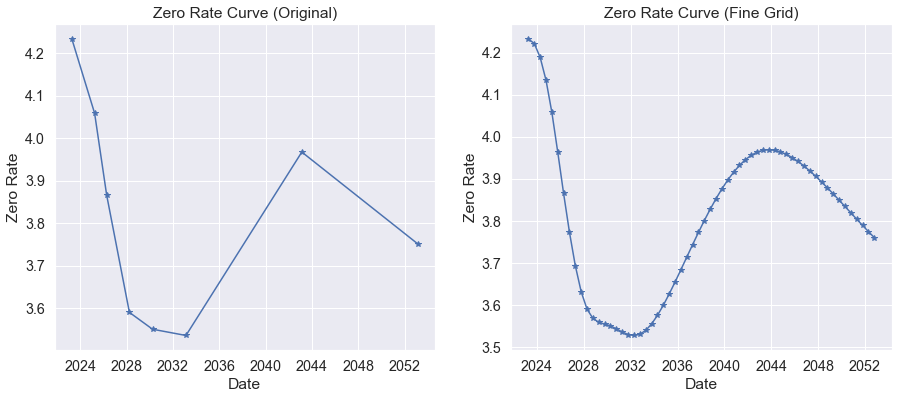

In [21]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.plot(yield_curve_df['Zero Rate'], marker='*')
plt.xlabel('Date')
plt.ylabel('Zero Rate')
plt.title('Zero Rate Curve (Original)')

plt.subplot(122)
plt.plot(yield_curve_grid_df['Zero Rate'], marker='*')
plt.xlabel('Date')
plt.ylabel('Zero Rate')
plt.title('Zero Rate Curve (Fine Grid)')

plt.show()

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

#### Discussion regarding Discount Factor Curve

- Below, we have graphed the discount factor curve using both the original grid (dates of the on-the-run treasuries) as well as a finer grid (additional dates included using a 6 months discretization grid)
- Both curves follow the same path, however as expected the one with a finer grid has a smoother curve as compared to the original grid
- The curves drop steadily from 2024 to 2052
- This suggests that the market is expecting interest rates to decline over this period. A discount factor represents the present value of future cash flows, and a lower discount factor indicates a higher present value, which in turn reflects lower interest rates

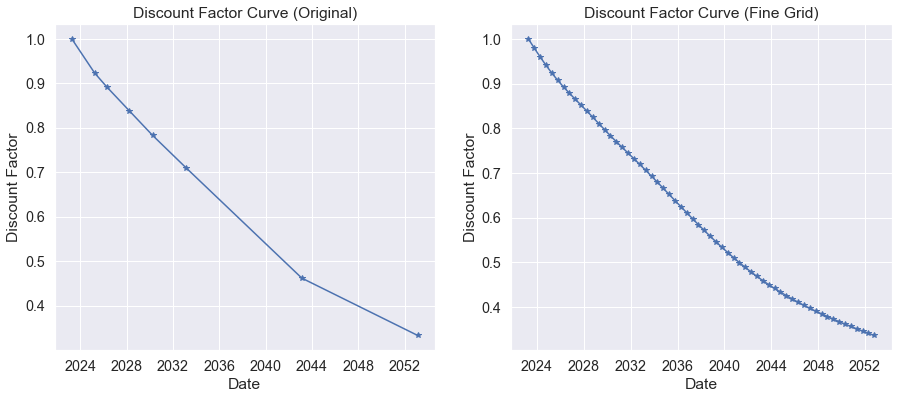

In [22]:
plt.subplots(figsize=(15,6))

plt.subplot(121)
plt.plot(yield_curve_df['Discount Factor'], marker='*')
plt.xlabel('Date')
plt.ylabel('Discount Factor')
plt.title('Discount Factor Curve (Original)')

plt.subplot(122)
plt.plot(yield_curve_grid_df['Discount Factor'], marker='*')
plt.xlabel('Date')
plt.ylabel('Discount Factor')
plt.title('Discount Factor Curve (Fine Grid)')

plt.show()

# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Present Value Calculation (no credit risk)" in the QuantLib introductory notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [23]:
mid_curve_handle = ql.YieldTermStructureHandle(mid_curve)

bond_engine = ql.DiscountingBondEngine(mid_curve_handle)

otr_objects = [otr_1, otr_2, otr_3, otr_4, otr_5, otr_6, otr_7]
clean_prices = []
implied_yields = []

for otr in otr_objects:
    otr.setPricingEngine(bond_engine)
    
    settle_date = otr.settlementDate(calc_date)
    clean_price = otr.cleanPrice()
    clean_prices.append(clean_price)
    
    implied_yield = otr.bondYield(clean_price, otr.dayCounter(), ql.Compounded, ql.Semiannual, settle_date) * 100
    implied_yields.append(implied_yield)

In [24]:
symbology_otr['calc_mid'] = clean_prices
symbology_otr['implied_yield'] = implied_yields

symbology_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,bid,ask,mid,bid_yield,ask_yield,mid_yield,Term,TTM,calc_mid,implied_yield
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,97.95,98.03,97.99,3.74,3.73,3.74,30.00,29.84,97.99,3.74
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,100.30,100.38,100.34,3.85,3.85,3.85,19.96,19.84,100.34,3.85
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,99.84,99.89,99.87,3.52,3.51,3.52,10.00,9.84,99.87,3.52
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,100.38,100.44,100.41,3.56,3.55,3.56,7.00,6.96,100.41,3.56
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,100.07,100.09,100.08,3.61,3.61,3.61,5.00,4.96,100.08,3.61
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,99.57,99.58,99.58,4.11,4.10,4.10,2.00,1.96,99.58,4.10
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,99.76,99.77,99.77,3.84,3.83,3.83,3.00,3.00,99.77,3.83


#### Discussion

- We use the mid yield curve from question 2b as the bond engine
- We use the cleanPrice() function to generate the prices for comparison, and we also calculate the implied yield using the bondYield() function which we will then use as our interest rate to calculate duration, convexity, and DV01
- As seen below, our answers perfectly match the market price and market yield up to 2 decimal places

In [25]:
comparison_df = pd.DataFrame(index=symbology_otr.figi, columns=['Clean Price', 'Market Price', 'Price Difference', \
                                                                'Implied Yield', 'Market Yield', 'Yield Difference'])

comparison_df['Clean Price'] = clean_prices
comparison_df['Market Price'] = symbology_otr.set_index('figi').mid
comparison_df['Price Difference'] = comparison_df['Clean Price'] - comparison_df['Market Price']
comparison_df['Implied Yield'] = implied_yields
comparison_df['Market Yield'] = symbology_otr.set_index('figi').mid_yield
comparison_df['Yield Difference'] = comparison_df['Implied Yield'] - comparison_df['Market Yield']

comparison_df

,Clean Price,Market Price,Price Difference,Implied Yield,Market Yield,Yield Difference
figi,,,,,,
BBG01DVKBH56,97.99,97.99,0.00,3.74,3.74,0.00
BBG01F6N6GN1,100.34,100.34,-0.00,3.85,3.85,0.00
BBG01DVKBC66,99.87,99.87,-0.00,3.52,3.52,-0.00
BBG01G14BV75,100.41,100.41,0.00,3.56,3.56,0.00
BBG01G14BW91,100.08,100.08,0.00,3.61,3.61,-0.00
BBG01G14BXX2,99.58,99.58,-0.00,4.10,4.10,0.00
BBG01G5ZMM43,99.77,99.77,-0.00,3.83,3.83,0.00


## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


#### Discussion

- BBG01DVKBH56 is the bond with the furthest maturity while BBG01G14BXX2 is the bond with the nearest maturity. As expected, duration, convexity, and DV01 are higher as the maturity of a bond increases
- Since the duration and DV01 have similar values, it implies that the bond has a linear risk profile
    - This suggests that the price sensitivity of the bond to changes in interest rates is roughly proportional across different yield levels
    - This means that if interest rates rise or fall by the same amount, the change in the bond's price will be roughly the same, regardless of whether interest rates are high or low

In [26]:
metrics = pd.DataFrame(index=symbology_otr.figi, columns=['dv01', 'duration', 'convexity'])

for i in range(len(otr_objects)):
    flat_int_rate = ql.InterestRate(implied_yields[i]/100, otr_objects[i].dayCounter(), ql.Compounded, ql.Semiannual)
    
    duration = ql.BondFunctions.duration(otr_objects[i], flat_int_rate)
    convexity = ql.BondFunctions.convexity(otr_objects[i], flat_int_rate)
    
    dirty_price = otr_objects[i].dirtyPrice()
    DV01 = duration * dirty_price / 100
    
    metrics.iloc[i, 0] = DV01
    metrics.iloc[i, 1] = duration
    metrics.iloc[i, 2] = convexity
    
metrics

,dv01,duration,convexity
figi,,,
BBG01DVKBH56,17.65,17.90,439.89
BBG01F6N6GN1,13.81,13.68,239.45
BBG01DVKBC66,8.25,8.21,78.85
BBG01G14BV75,6.13,6.09,42.89
BBG01G14BW91,4.50,4.49,23.41
BBG01G14BXX2,1.85,1.86,4.43
BBG01G5ZMM43,2.80,2.81,9.47


In [27]:
symbology_otr['dv01'] = list(metrics['dv01'])
symbology_otr['duration'] = list(metrics['duration'])
symbology_otr['convexity'] = list(metrics['convexity'])

symbology_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,bid_yield,ask_yield,mid_yield,Term,TTM,calc_mid,implied_yield,dv01,duration,convexity
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,3.74,3.73,3.74,30.00,29.84,97.99,3.74,17.65,17.90,439.89
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,3.85,3.85,3.85,19.96,19.84,100.34,3.85,13.81,13.68,239.45
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,3.52,3.51,3.52,10.00,9.84,99.87,3.52,8.25,8.21,78.85
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,3.56,3.55,3.56,7.00,6.96,100.41,3.56,6.13,6.09,42.89
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,3.61,3.61,3.61,5.00,4.96,100.08,3.61,4.50,4.49,23.41
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,4.11,4.10,4.10,2.00,1.96,99.58,4.10,1.85,1.86,4.43
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,3.84,3.83,3.83,3.00,3.00,99.77,3.83,2.80,2.81,9.47


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [28]:
shock_metrics = pd.DataFrame(index=symbology_otr.figi, columns=['scen_dv01', 'scen_duration', 'scen_convexity'])

for i in range(len(otr_objects)):
    interest_rate_bump = ql.SimpleQuote(0.0)
    flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(mid_curve_handle, ql.QuoteHandle(interest_rate_bump))

    bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))
    otr_objects[i].setPricingEngine(bond_engine)
    
    base = otr_objects[i].NPV()
    dirty_price = otr_objects[i].dirtyPrice()
    
    interest_rate_bump.setValue(-0.0001)
    neg_bump = otr_objects[i].NPV()
    
    DV01 = (neg_bump - base) * 100
    
    duration = DV01 / dirty_price * 100
    
    interest_rate_bump.setValue(0.0001)
    pos_bump = otr_objects[i].NPV()

    convexity = (neg_bump - 2 * base + pos_bump) * 1000000  / dirty_price * 100

    clean_price = otr_objects[i].cleanPrice()
    settle_date = otr_objects[i].settlementDate(calc_date)

    shock_metrics.iloc[i, 0] = DV01
    shock_metrics.iloc[i, 1] = duration
    shock_metrics.iloc[i, 2] = convexity

#### Discussion

- The scenario metrics computed below are very similar to the metrics we computed in part b. This confirms our answer in part b that the bond has a linear risk profile
- It suggests that the bond or portfolio's price sensitivity to changes in interest rates is roughly proportional across different levels of yield changes
- A linear risk profile can be beneficial in certain situations, such as when a portfolio manager wants to maintain a consistent level of interest rate risk exposure across different parts of the yield curve

In [29]:
shock_metrics

,scen_dv01,scen_duration,scen_convexity
figi,,,
BBG01DVKBH56,17.97,18.23,446.82
BBG01F6N6GN1,14.01,13.88,239.62
BBG01DVKBC66,8.40,8.36,77.56
BBG01G14BV75,6.29,6.25,41.94
BBG01G14BW91,4.63,4.62,22.42
BBG01G14BXX2,1.94,1.94,3.84
BBG01G5ZMM43,2.86,2.86,8.44


In [30]:
for col in shock_metrics.columns:
    symbology_otr[col] = list(shock_metrics[col])

symbology_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,Term,TTM,calc_mid,implied_yield,dv01,duration,convexity,scen_dv01,scen_duration,scen_convexity
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,30.00,29.84,97.99,3.74,17.65,17.90,439.89,17.97,18.23,446.82
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,19.96,19.84,100.34,3.85,13.81,13.68,239.45,14.01,13.88,239.62
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.50,FIXED,...,10.00,9.84,99.87,3.52,8.25,8.21,78.85,8.40,8.36,77.56
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,7.00,6.96,100.41,3.56,6.13,6.09,42.89,6.29,6.25,41.94
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.62,FIXED,...,5.00,4.96,100.08,3.61,4.50,4.49,23.41,4.63,4.62,22.42
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.88,FIXED,...,2.00,1.96,99.58,4.10,1.85,1.86,4.43,1.94,1.94,3.84
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.75,FIXED,...,3.00,3.00,99.77,3.83,2.80,2.81,9.47,2.86,2.86,8.44


# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the on-the-run corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects.

In [31]:
corp_otr = symbology[symbology['class'] == 'Corp']
corp_otr = corp_otr.reset_index(drop=True)
corp_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,days_settle,start_date,cpn_first,acc_first,maturity,country,currency,und_bench_isin,mty_typ,rank
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,US,USD,US91282CGU99,CALLABLE,Sr Unsecured
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,US,USD,US91282CGU99,CALLABLE,Sr Unsecured
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.38,FIXED,...,2,2019-11-22,2020-05-15,2019-11-15,2026-11-15,US,USD,US91282CGR60,CALLABLE,Sr Unsecured
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.55,FIXED,...,2,2019-11-22,2020-03-15,2019-09-15,2033-03-15,US,USD,US91282CGM73,AT MATURITY,Sr Unsecured
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.20,FIXED,...,2,2019-11-22,2019-12-15,2019-06-15,2034-12-15,US,USD,US91282CGM73,AT MATURITY,Sr Unsecured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.15,FIXED,...,2,2022-05-19,2022-11-15,2022-05-19,2029-05-15,US,USD,US91282CGT27,CALLABLE,Sr Unsecured
215,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.65,FIXED,...,2,2022-06-03,2022-12-15,2022-06-03,2052-06-15,US,USD,US912810TL26,CALLABLE,Sr Unsecured
216,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.60,FIXED,...,2,2022-08-11,2023-02-15,2022-08-11,2052-08-15,US,USD,US912810TL26,CALLABLE,Sr Unsecured
217,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.50,FIXED,...,2,2022-09-22,2023-03-15,2022-09-22,2029-09-15,US,USD,US91282CGT27,CALLABLE,Sr Unsecured


In [32]:
corp_otr = corp_otr.merge(market_prices_eod, on=['ticker', 'figi', 'isin'])
corp_otr['Term'] = (corp_otr['maturity'] - corp_otr['start_date']).dt.days / 365.25
corp_otr['Current'] = pd.to_datetime('2023-04-14')
corp_otr['TTM'] = (corp_otr['maturity'] - corp_otr['Current']).dt.days / 365.25
corp_otr = corp_otr.drop(['Current'], axis=1)
corp_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,rank,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,Term,TTM
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,Sr Unsecured,2023-04-14,98.68,98.85,98.76,4.68,4.55,4.62,4.82,1.42
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,Sr Unsecured,2023-04-14,98.45,98.82,98.64,4.36,4.20,4.28,5.90,2.51
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.38,FIXED,...,Sr Unsecured,2023-04-14,97.09,97.37,97.23,4.26,4.17,4.22,6.98,3.59
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.55,FIXED,...,Sr Unsecured,2023-04-14,115.16,115.98,115.57,4.62,4.53,4.58,13.31,9.92
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.20,FIXED,...,Sr Unsecured,2023-04-14,112.94,113.59,113.26,4.74,4.67,4.71,15.06,11.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.15,FIXED,...,Sr Unsecured,2023-04-14,95.24,96.34,95.79,5.07,4.85,4.96,6.99,6.09
215,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.65,FIXED,...,Sr Unsecured,2023-04-14,86.78,89.21,87.99,5.57,5.39,5.48,30.03,29.17
216,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.60,FIXED,...,Sr Unsecured,2023-04-14,86.53,88.97,87.75,5.53,5.35,5.44,30.01,29.34
217,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.50,FIXED,...,Sr Unsecured,2023-04-14,97.81,99.07,98.44,4.90,4.67,4.79,6.98,6.42


#### Creating three Corporate Bond objects for testing (the rest are created in part b)

In [33]:
corp_1 = create_bond_from_symbology(corp_otr.iloc[0])
corp_2 = create_bond_from_symbology(corp_otr.iloc[1])
corp_3 = create_bond_from_symbology(corp_otr.iloc[2])

## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [34]:
bond_engine = ql.DiscountingBondEngine(mid_curve_handle)

implied_yields = []
zspreads = []
clean_prices = []

for i in range(len(corp_otr)):
    otr = create_bond_from_symbology(corp_otr.iloc[i])
    
    otr.setPricingEngine(bond_engine)
    
    settle_date = otr.settlementDate(calc_date)
    clean_price = corp_otr.iloc[i].mid
    
    implied_yield = otr.bondYield(clean_price, otr.dayCounter(), ql.Compounded, ql.Semiannual, settle_date) * 100
    implied_yields.append(implied_yield)
    
    zspread = ql.BondFunctions.zSpread(otr, clean_price, mid_curve, otr.dayCounter(), ql.Compounded, \
                                       ql.Semiannual, settle_date)
    zspreads.append(zspread)

#### Discussion

- We use the mid yield curve from question 2b as the bond engine
- We use the mid market prices as the clean price, and we also calculate the implied yield using the bondYield() function which we will then use as our interest rate to calculate duration, convexity, and DV01
- For the zspread calculation, we also use the mid market prices as the clean price and use the zSpread() function for the calculation and display the values in bps

In [35]:
corp_metrics = pd.DataFrame(index=corp_otr.figi, columns=['calc_yield', 'calc_zspread'])

corp_metrics['calc_yield'] = implied_yields
corp_metrics['calc_zspread'] = zspreads
corp_metrics['calc_zspread'] *= 10000

corp_metrics

,calc_yield,calc_zspread
figi,,
BBG00QNKJ092,4.61,52.02
BBG00QNKPCL5,4.28,35.72
BBG00QNKGJP6,4.22,48.53
BBG00QNKP8R8,4.58,104.86
BBG00QNKR4J4,4.71,113.27
...,...,...
BBG017BR3G75,4.96,141.43
BBG017QYK9Z0,5.48,173.35
BBG0191HMXJ3,5.44,169.69


In [36]:
corp_otr['calc_yield'] = list(corp_metrics['calc_yield'])
corp_otr['calc_zspread'] = list(corp_metrics['calc_zspread'])

corp_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,bid,ask,mid,bid_yield,ask_yield,mid_yield,Term,TTM,calc_yield,calc_zspread
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,98.68,98.85,98.76,4.68,4.55,4.62,4.82,1.42,4.61,52.02
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,98.45,98.82,98.64,4.36,4.20,4.28,5.90,2.51,4.28,35.72
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.38,FIXED,...,97.09,97.37,97.23,4.26,4.17,4.22,6.98,3.59,4.22,48.53
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.55,FIXED,...,115.16,115.98,115.57,4.62,4.53,4.58,13.31,9.92,4.58,104.86
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.20,FIXED,...,112.94,113.59,113.26,4.74,4.67,4.71,15.06,11.67,4.71,113.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.15,FIXED,...,95.24,96.34,95.79,5.07,4.85,4.96,6.99,6.09,4.96,141.43
215,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.65,FIXED,...,86.78,89.21,87.99,5.57,5.39,5.48,30.03,29.17,5.48,173.35
216,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.60,FIXED,...,86.53,88.97,87.75,5.53,5.35,5.44,30.01,29.34,5.44,169.69
217,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.50,FIXED,...,97.81,99.07,98.44,4.90,4.67,4.79,6.98,6.42,4.78,124.05


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

Pick 3 corporate bonds (at your discretion) and use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 9. "Duration, Convexity and Z-Spread (flat yield model)".

Validate that you match the original market price, which were used as input to the z-Spread function.


In [37]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, \
                                                      ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price

In [38]:
clean_1 = calc_clean_price_with_zspread(corp_1, mid_curve_handle, zspreads[0])
clean_2 = calc_clean_price_with_zspread(corp_2, mid_curve_handle, zspreads[1])
clean_3 = calc_clean_price_with_zspread(corp_3, mid_curve_handle, zspreads[2])

#### Discussion

- We choose the first 3 corporate bonds to test whether we are able to match the original market price
- Using the zspreads and the calc_clean_price_with_zspread function, we get the clean price that has to be compared with the original market price
- As seen below, our answers perfectly match the market price up to 2 decimal places

In [39]:
comparison_corp = pd.DataFrame(index=corp_otr.figi[:3], columns=['Clean Price', 'Market Price', 'Price Difference'])

comparison_corp['Clean Price'] = [clean_1, clean_2, clean_3]
comparison_corp['Market Price'] = corp_otr.iloc[:3].set_index('figi').mid
comparison_corp['Price Difference'] = comparison_corp['Clean Price'] - comparison_corp['Market Price']

comparison_corp

,Clean Price,Market Price,Price Difference
figi,,,
BBG00QNKJ092,98.76,98.76,0.00
BBG00QNKPCL5,98.64,98.64,-0.00
BBG00QNKGJP6,97.23,97.23,0.00


## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|


#### Discussion

- As expected, duration, convexity, and DV01 are higher as the maturity of a corporate bond increases

In [40]:
corp_metrics = pd.DataFrame(index=corp_otr.figi, columns=['duration', 'convexity'])

for i in range(len(corp_otr)):
    otr = create_bond_from_symbology(corp_otr.iloc[i])
    
    otr.setPricingEngine(bond_engine)
    
    flat_int_rate = ql.InterestRate(implied_yields[i]/100, otr.dayCounter(), ql.Compounded, ql.Semiannual)
    
    duration = ql.BondFunctions.duration(otr, flat_int_rate)
    convexity = ql.BondFunctions.convexity(otr, flat_int_rate)
    
    corp_metrics.iloc[i, 0] = duration
    corp_metrics.iloc[i, 1] = convexity
    
corp_metrics

,duration,convexity
figi,,
BBG00QNKJ092,1.35,2.50
BBG00QNKPCL5,2.35,6.80
BBG00QNKGJP6,3.28,12.85
BBG00QNKP8R8,7.43,68.60
BBG00QNKR4J4,8.33,88.59
...,...,...
BBG017BR3G75,5.19,31.99
BBG017QYK9Z0,14.71,326.34
BBG0191HMXJ3,14.95,333.86


In [41]:
corp_otr['calc_duration'] = list(corp_metrics['duration'])
corp_otr['calc_convexity'] = list(corp_metrics['convexity'])

corp_otr

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mid,bid_yield,ask_yield,mid_yield,Term,TTM,calc_yield,calc_zspread,calc_duration,calc_convexity
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,98.76,4.68,4.55,4.62,4.82,1.42,4.61,52.02,1.35,2.50
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.70,FIXED,...,98.64,4.36,4.20,4.28,5.90,2.51,4.28,35.72,2.35,6.80
2,DIS,Corp,BBG00QNKGJP6,US254687DK97,DIS4907439,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.38,FIXED,...,97.23,4.26,4.17,4.22,6.98,3.59,4.22,48.53,3.28,12.85
3,DIS,Corp,BBG00QNKP8R8,US254687DV52,DIS4908605,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,GLOBAL,6.55,FIXED,...,115.57,4.62,4.53,4.58,13.31,9.92,4.58,104.86,7.43,68.60
4,DIS,Corp,BBG00QNKR4J4,US254687DZ66,DIS4908062,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,GLOBAL,6.20,FIXED,...,113.26,4.74,4.67,4.71,15.06,11.67,4.71,113.27,8.33,88.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.15,FIXED,...,95.79,5.07,4.85,4.96,6.99,6.09,4.96,141.43,5.19,31.99
215,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.65,FIXED,...,87.99,5.57,5.39,5.48,30.03,29.17,5.48,173.35,14.71,326.34
216,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.60,FIXED,...,87.75,5.53,5.35,5.44,30.01,29.34,5.44,169.69,14.95,333.86
217,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.50,FIXED,...,98.44,4.90,4.67,4.79,6.98,6.42,4.78,124.05,5.48,35.32
